In [1]:
#Training the model on 30k datasets.

import random
import numpy as np
from Bio import SeqIO
import gzip
import os
import pickle
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt

#Set random seeds for reproducibility.
np.random.seed(4)
random.seed(5)
set_random_seed(4) 



def load_data(path):   
    data = gzip.open(os.path.join(path,"sequences.fa.gz"),"rt")
    return data


def get_seq(protein, t_data, training_set_number): 
    if t_data == "train":
                
        training_data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((30000,101,4))          
    
    elif t_data == "test":    
                
        training_data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((10000,101,4))      
      
    r = 0    
      
    
    for record in SeqIO.parse(training_data,"fasta"):
        sequence = list(record.seq)                
        nucleotide = {'A' : 0, 'T' : 1, 'G' : 2, 'C' : 3, 'N' : 4} 
        num_seq = list() #sekvenca v številskem formatu


        for i in range(0,len(sequence)):
                num_seq.append(nucleotide[sequence[i]])


        X = np.zeros((1,len(num_seq),4))

        
        for i in range (len(num_seq)):
                if num_seq[i] <= 3:
                    X[:,i,num_seq[i]] = 1               

        x_train[r,:,:] = X
        r = r + 1
    
    return x_train


def get_class(protein, t_data,training_set_number):
    y_train = []
    

    if t_data == 'train':
        data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))

    elif t_data == 'test':
        data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))


    for record in SeqIO.parse(data,"fasta"):
        v = int((record.description).split(":")[1])
        # [1,0] if there was no observed binding and [0,1] for sequences where binding was observed.
        y_train.append([int(v == 0), int(v != 0)])

    y_train = np.array(y_train)
    return y_train


def get_cobinding(protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
            
        cobinding = np.zeros((30000,101,cobinding_data.shape[1]/101),dtype=np.int)    
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
        cobinding = np.zeros((10000,101,cobinding_data.shape[1]/101),dtype=np.int)
   
    
    for n in range(0,cobinding_data.shape[1],101):
        a = cobinding_data[:,n:(n+101)]
        cobinding[:,:,(n/101)] = a
    
    return cobinding
    

def get_region (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1)
        region = np.zeros((30000,101,region_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1) 
        region = np.zeros((10000,101,region_data.shape[1]/101),dtype=np.int)
    

    for n in range(0,region_data.shape[1],101):
        a = region_data[:,n:(n+101)]
        region[:,:,(n/101)] = a
        
    return region


def get_fold (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((30000,101,fold_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((10000,101,fold_data.shape[1]/101),dtype=np.int)




    for n in range(0,fold_data.shape[1],101):
        a = fold_data[:,n:(n+101)]
        fold[:,:,(n/101)] = a
    
    
    return fold

def load_data_sources(protein, t_data, training_set_number, *args):
    X = np.array([])
    data_sources = []
    for arg in args:
        
        if arg == 'KMER':
            if X.size == 0:
                X = get_seq(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_seq(protein, t_data, training_set_number)))
        if arg == 'RNA': 
            if X.size == 0:
                X = get_fold(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_fold(protein, t_data, training_set_number)))
        if arg == 'RG':   
            if X.size == 0:
                X = get_region(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_region(protein, t_data, training_set_number)))
        if arg == 'CLIP': 
            if X.size == 0:
                X = get_cobinding(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_cobinding(protein, t_data, training_set_number)))
        data_sources.append(arg)
        
    data_sources = ','.join(data_sources)
    return data_sources, X


Using TensorFlow backend.


In [ ]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations
from keras.models import model_from_json

protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
                
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
    

        #Load data for testing purposes.
        data_sources, X_test = load_data_sources(protein, 'test', training_set_number, *experiment_set)

        #We are interested in the last dense layer of the network.
        layer_index = -1
        model.layers[layer_index].activation = activations.linear
        model = utils.apply_modifications(model)
        
        #We generate the input that maximizes the filter output activation. 
        activation = visualize_activation(model, layer_index, filter_indices = 1 ,input_range = (0,2))
                                                               
        with open ("results/set_%s/%s/activation_maximization" % (training_set_number, protein), "w") as activation_maximization_f:
            np.save(activation_maximization_f, activation)
        
        plt.figure(3)
        plt.imshow(activation, cmap = 'jet')
        plt.show()


In [ ]:
protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)

        with open ("results/set_%s/%s/activation_maximization" % (training_set_number, protein), "r") as activation_maximization_f:
            activation = np.load(activation_maximization_f)
            
            nucleotides = {'A' : activation[:,0], 'T' : activation[:,1], 'G' : activation[:,2], 'C' : activation[:,3]} 
            position_count = np.sum(activation[:,0:4],1)

            for entry in nucleotides:
                nucleotides[entry] = np.nan_to_num(np.true_divide(nucleotides[entry],position_count))
                
            with open ("results/set_%s/%s/max_activation_sequences.txt" % (training_set_number, protein), "w") as sequences_f:
                 sequences_f.write('P0 A U G C\n')
                    
            for i in range (len(nucleotides['A'])):
                 with open ("results/set_%s/%s/max_activation_sequences.txt" % (training_set_number, protein), "a") as sequences_f:
                    sequences_f.write('P{} {} {} {} {}\n'.format(i+1, nucleotides['A'][i], nucleotides['T'][i], nucleotides['G'][i], nucleotides['C'][i]))
 
                

1_PARCLIP_AGO1234_hg19


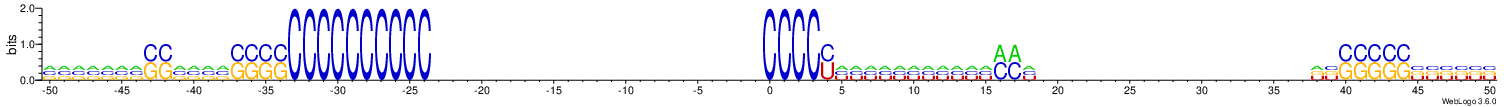

2_PARCLIP_AGO2MNASE_hg19


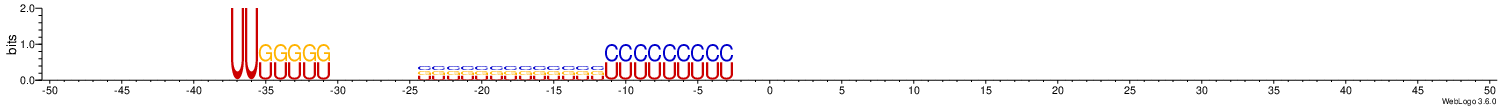

3_HITSCLIP_Ago2_binding_clusters


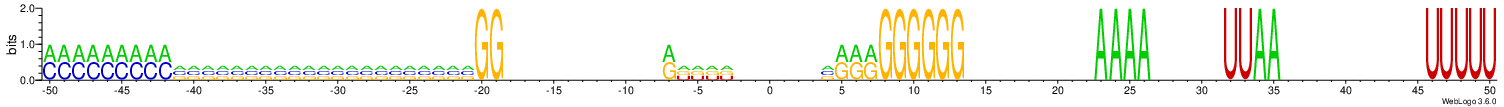

4_HITSCLIP_Ago2_binding_clusters_2


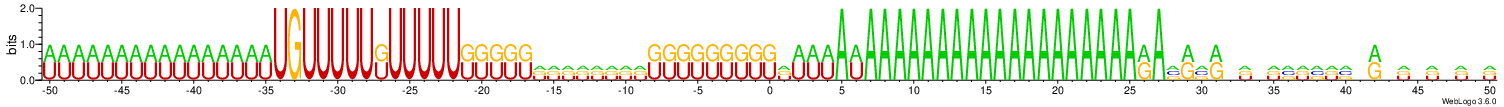

5_CLIPSEQ_AGO2_hg19


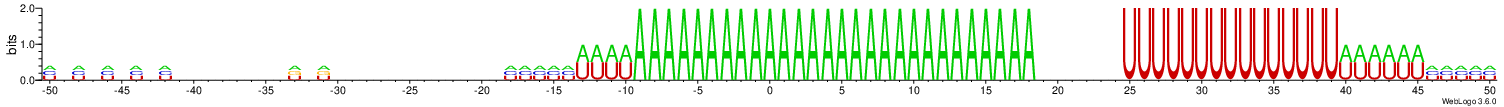

6_CLIP-seq-eIF4AIII_1


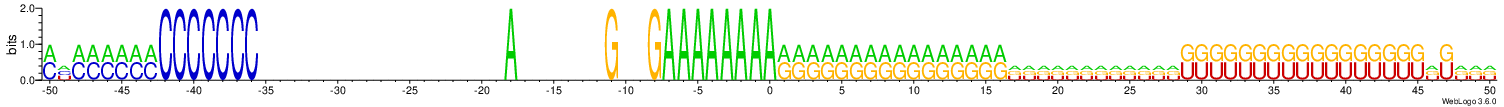

7_CLIP-seq-eIF4AIII_2


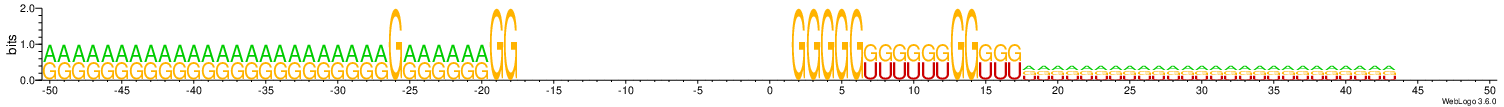

8_PARCLIP_ELAVL1_hg19


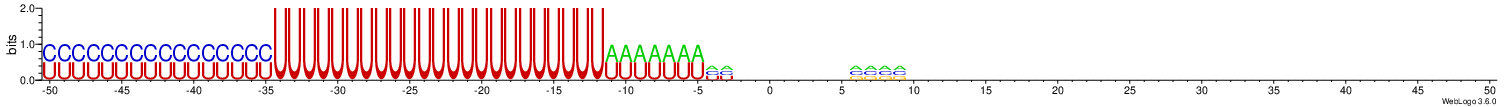

9_PARCLIP_ELAVL1MNASE_hg19


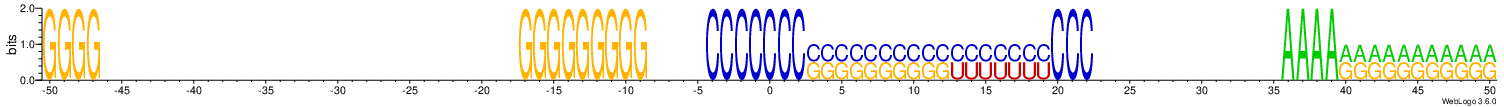

10_PARCLIP_ELAVL1A_hg19


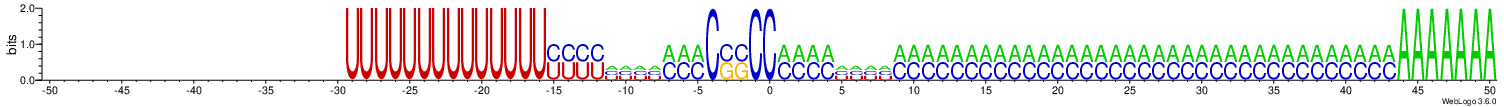

10_PARCLIP_ELAVL1A_hg19


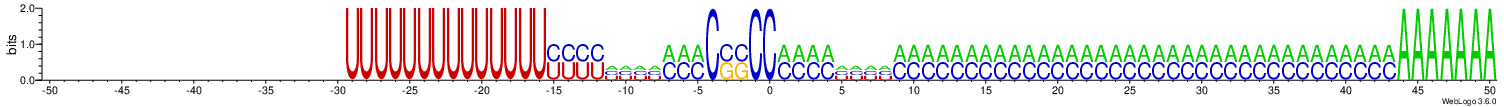

12_PARCLIP_EWSR1_hg19


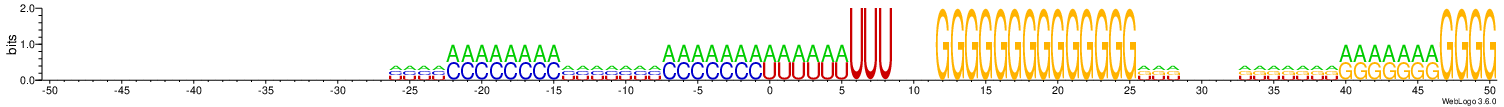

13_PARCLIP_FUS_hg19


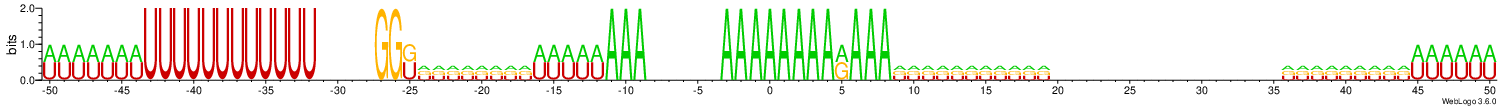

14_PARCLIP_FUS_mut_hg19


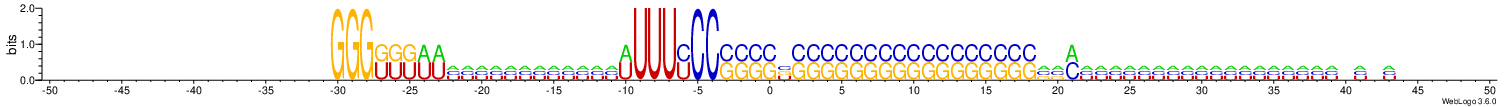

15_PARCLIP_IGF2BP123_hg19


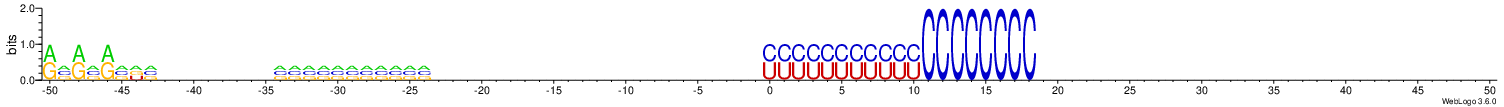

16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters


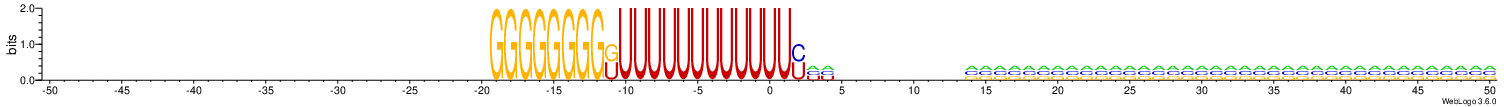

17_ICLIP_HNRNPC_hg19


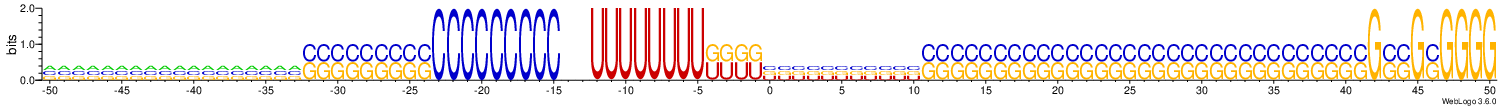

18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome


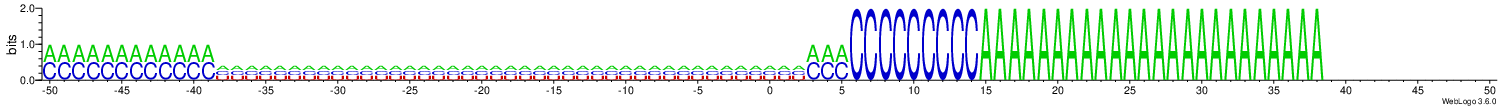

19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome


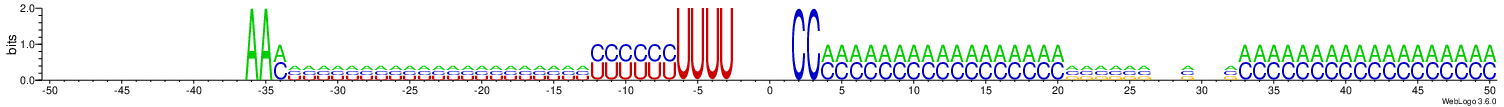

20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome


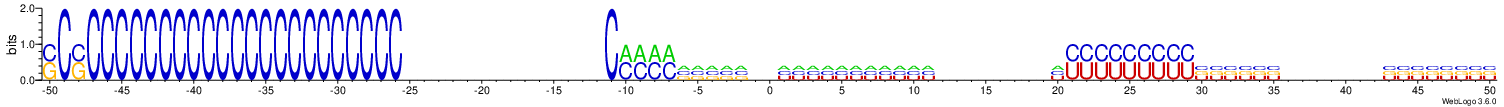

21_PARCLIP_MOV10_Sievers_hg19


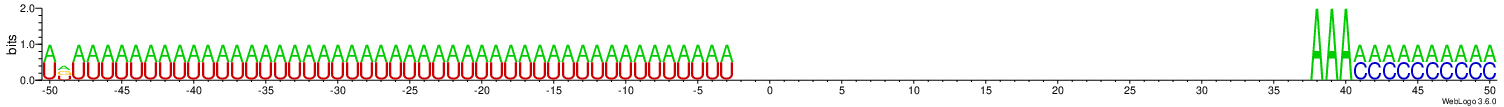

22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome


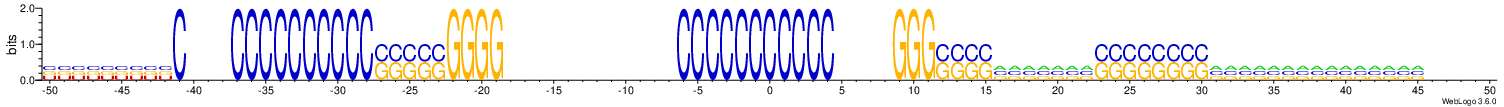

23_PARCLIP_PUM2_hg19


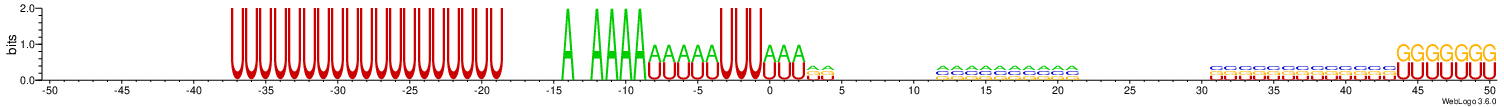

24_PARCLIP_QKI_hg19


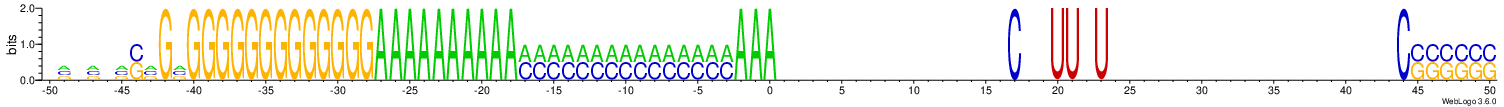

25_CLIPSEQ_SFRS1_hg19


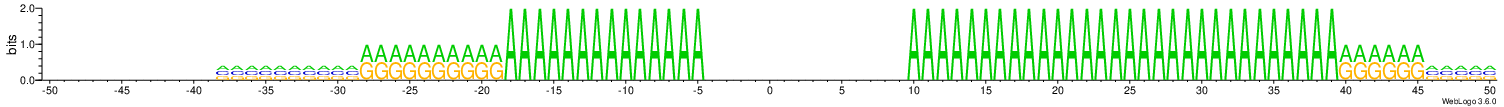

26_PARCLIP_TAF15_hg19


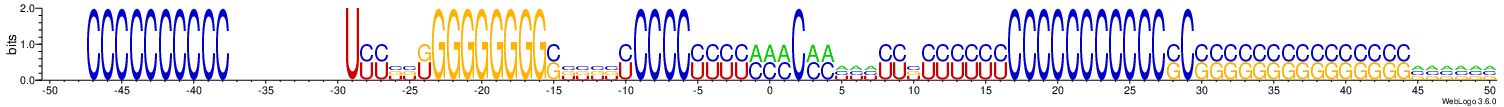

27_ICLIP_TDP43_hg19


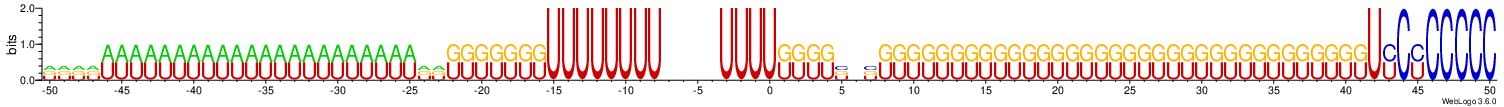

28_ICLIP_TIA1_hg19


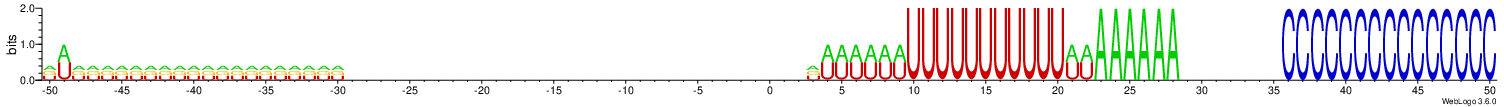

29_ICLIP_TIAL1_hg19


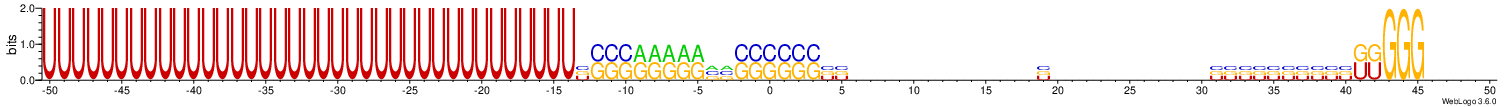

30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters


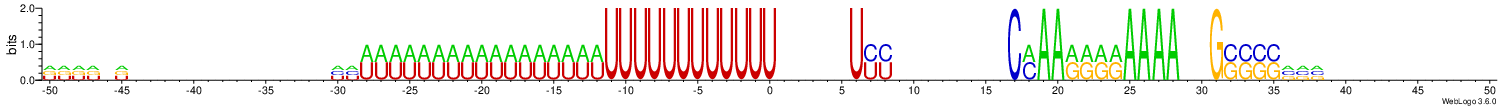

31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters


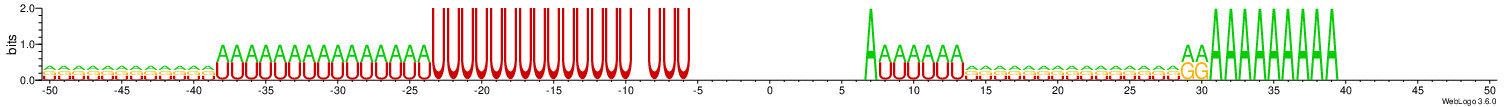

In [2]:
from IPython.display import display, Image
import os


protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        cmd = ("weblogo -f results/set_%s/%s/max_activation_sequences.txt -D transfac -F png -o results/set_%s/%s/max_activation.png --errorbars NO --show-xaxis YES --show-yaxis YES --first-index '-50' -A rna --composition none -n 101 --color '#00CC00' 'A' 'A' --color '#0000CC' 'C' 'C' --color '#FFB300' 'G' 'G' --color '#CC0000' 'U' 'U' " % (training_set_number, protein, training_set_number, protein)) 
        os.system(cmd)
        display(Image('results/set_%s/%s/max_activation.png' % (training_set_number, protein)))

1_PARCLIP_AGO1234_hg19
(array([[1, 0, 1, 1],
       [1, 0, 1, 1],
       [1, 0, 1, 1],
       [1, 0, 1, 1],
       [1, 0, 1, 1],
       [1, 0, 1, 1],
       [1, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [1, 0, 1, 1],
       [1, 0, 1, 1],
       [1, 0, 1, 1],
       [1, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0,

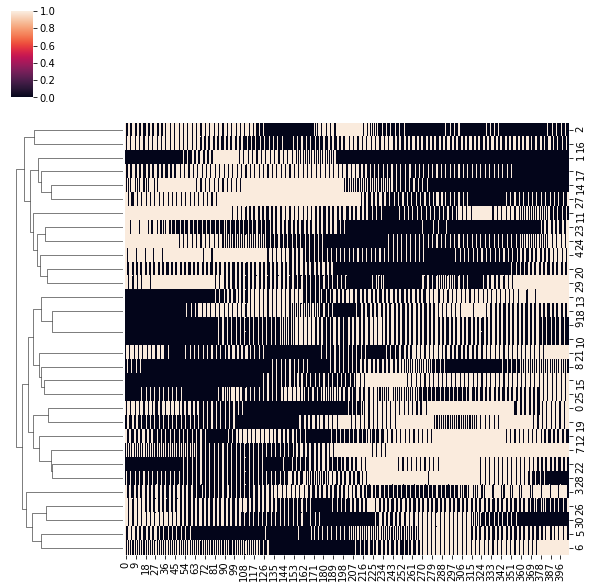

In [21]:
import seaborn as sns

protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

for training_set_number in range (1):
    
    activations = np.zeros((31,404))
    
    for i, protein in enumerate(protein_list):
        print (protein)

        with open ("results/set_%s/%s/activation_maximization" % (training_set_number, protein), "r") as activation_maximization_f:
            activation = np.load(activation_maximization_f)
            print (activation[:,0:4],activation[:,0:4].reshape((1,-1)))
            activations[i] = activation[:,0:4].reshape((1,-1))
            
g = sns.clustermap(activations, col_cluster = False)

1_PARCLIP_AGO1234_hg19


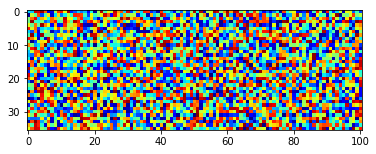

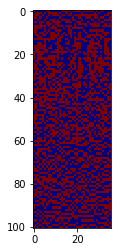

2_PARCLIP_AGO2MNASE_hg19


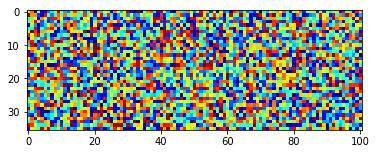

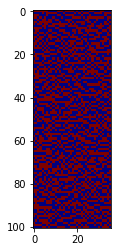

3_HITSCLIP_Ago2_binding_clusters


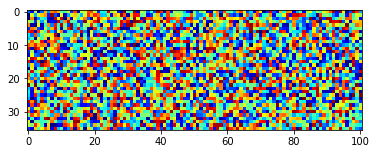

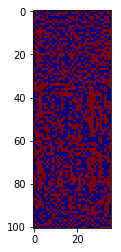

4_HITSCLIP_Ago2_binding_clusters_2


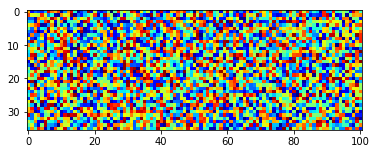

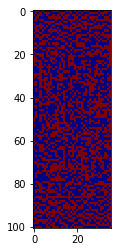

5_CLIPSEQ_AGO2_hg19


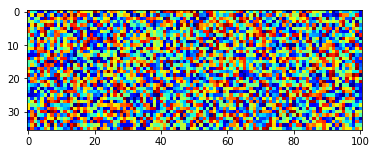

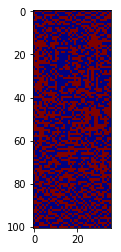

6_CLIP-seq-eIF4AIII_1


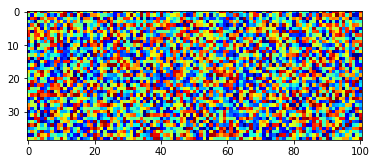

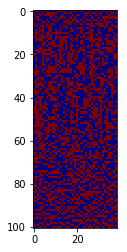

7_CLIP-seq-eIF4AIII_2


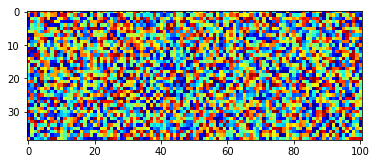

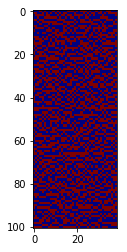

8_PARCLIP_ELAVL1_hg19


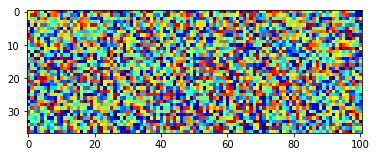

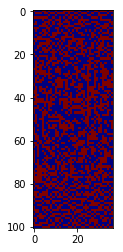

9_PARCLIP_ELAVL1MNASE_hg19


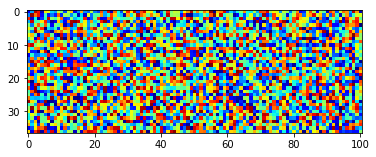

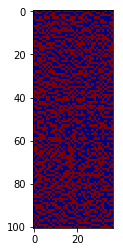

10_PARCLIP_ELAVL1A_hg19


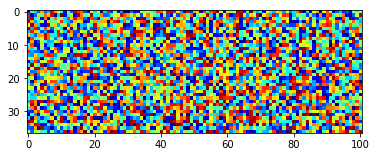

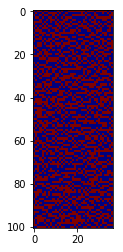

10_PARCLIP_ELAVL1A_hg19


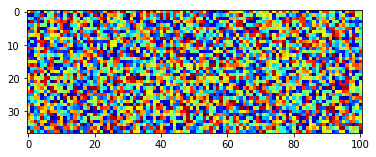

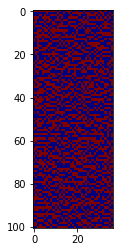

12_PARCLIP_EWSR1_hg19


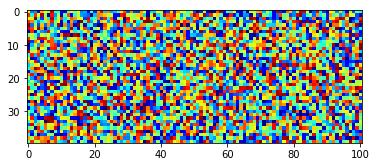

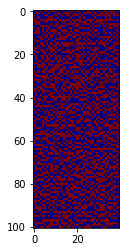

13_PARCLIP_FUS_hg19


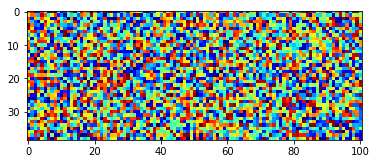

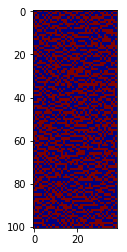

14_PARCLIP_FUS_mut_hg19


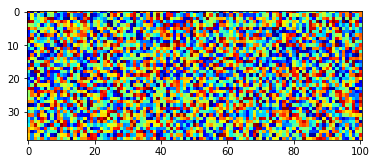

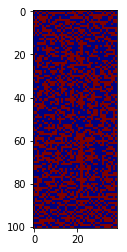

15_PARCLIP_IGF2BP123_hg19


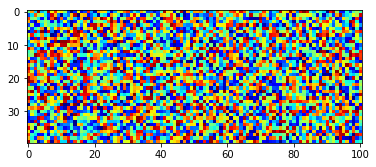

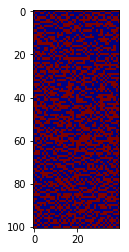

16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters


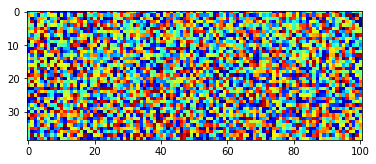

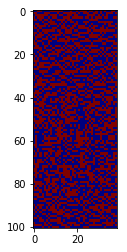

17_ICLIP_HNRNPC_hg19


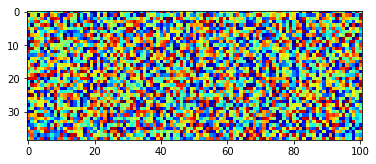

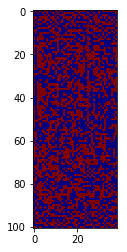

18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome


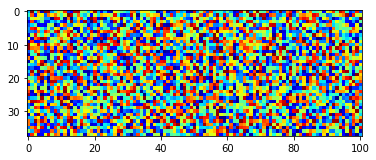

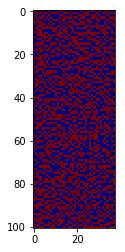

19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome


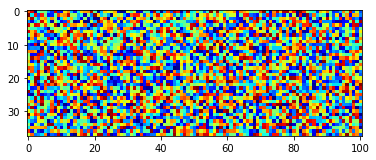

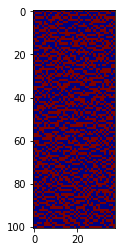

20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome


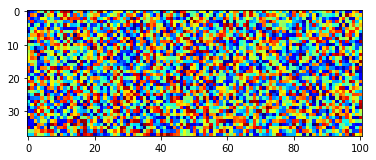

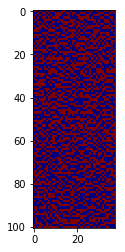

21_PARCLIP_MOV10_Sievers_hg19


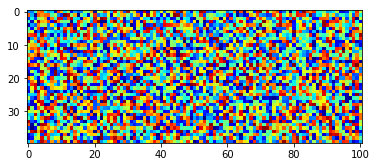

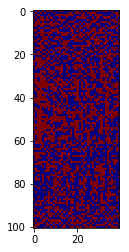

22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome


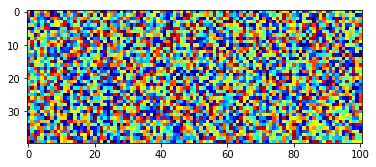

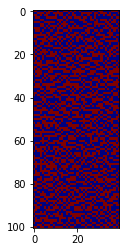

23_PARCLIP_PUM2_hg19


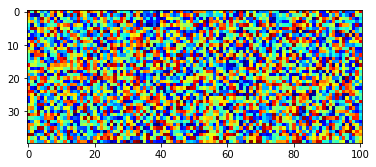

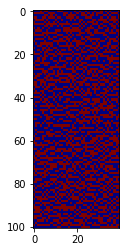

24_PARCLIP_QKI_hg19


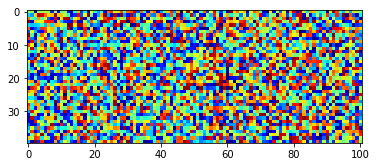

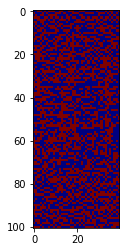

25_CLIPSEQ_SFRS1_hg19


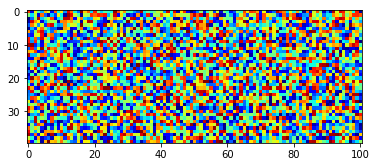

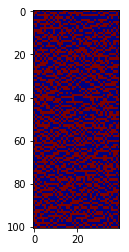

26_PARCLIP_TAF15_hg19


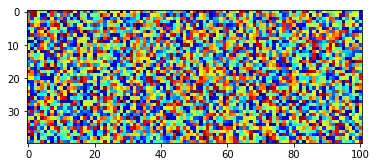

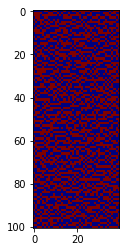

27_ICLIP_TDP43_hg19


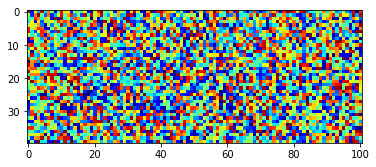

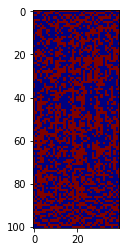

28_ICLIP_TIA1_hg19


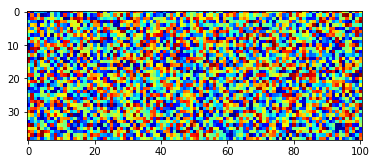

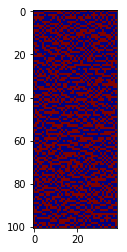

29_ICLIP_TIAL1_hg19


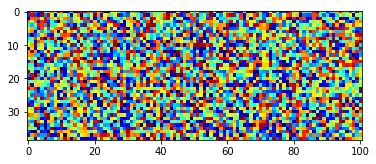

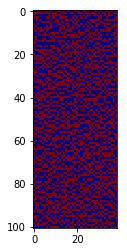

30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters


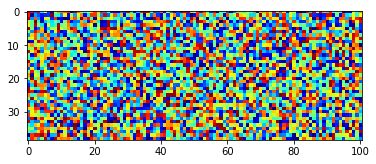

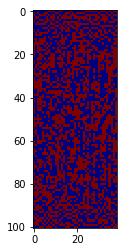

31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters


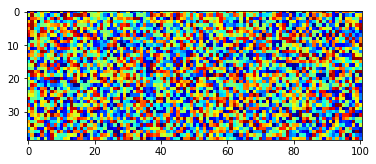

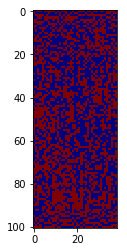

In [4]:
import pickle
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations
from keras.models import model_from_json

protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

with open ("data_matrix_dimensions", "r") as pickle_file:
        data_matrix_dim = pickle.load(pickle_file)

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
                
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
    

            #Load data for testing purposes.
            data_sources, X_test = load_data_sources(protein, 'test', training_set_number, *experiment_set)

            #We are interested in the last dense layer of the network.
            layer_index = -1
            #model.layers[layer_index].activation = activations.linear
            #model = utils.apply_modifications(model)
            seed_input = np.random.rand(1,101,int(sum(data_matrix_dim[protein])))
            #We generate the input that maximizes the filter output activation. 
            activation = visualize_activation(model, layer_index, filter_indices = 0 ,input_range = (0,2), seed_input = seed_input)

            with open ("results/set_%s/%s/activation_maximization_2" % (training_set_number, protein), "w") as activation_maximization_f:
                np.save(activation_maximization_f, activation)

            plt.figure(3)
            plt.imshow(seed_input.reshape(-1, 101), cmap = 'jet')
            plt.show()
            plt.imshow(activation, cmap = 'jet')
            plt.show()
        
        

1_PARCLIP_AGO1234_hg19
2_PARCLIP_AGO2MNASE_hg19
3_HITSCLIP_Ago2_binding_clusters


/local/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


4_HITSCLIP_Ago2_binding_clusters_2
5_CLIPSEQ_AGO2_hg19
6_CLIP-seq-eIF4AIII_1
7_CLIP-seq-eIF4AIII_2
8_PARCLIP_ELAVL1_hg19
9_PARCLIP_ELAVL1MNASE_hg19
10_PARCLIP_ELAVL1A_hg19
10_PARCLIP_ELAVL1A_hg19
12_PARCLIP_EWSR1_hg19
13_PARCLIP_FUS_hg19
14_PARCLIP_FUS_mut_hg19
15_PARCLIP_IGF2BP123_hg19
16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters
17_ICLIP_HNRNPC_hg19
18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome
19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome
20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome
21_PARCLIP_MOV10_Sievers_hg19
22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome
23_PARCLIP_PUM2_hg19
24_PARCLIP_QKI_hg19
25_CLIPSEQ_SFRS1_hg19
26_PARCLIP_TAF15_hg19
27_ICLIP_TDP43_hg19
28_ICLIP_TIA1_hg19
29_ICLIP_TIAL1_hg19

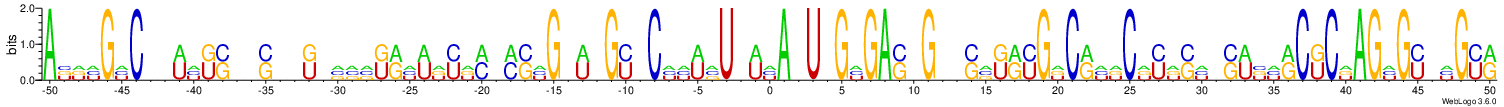

2_PARCLIP_AGO2MNASE_hg19


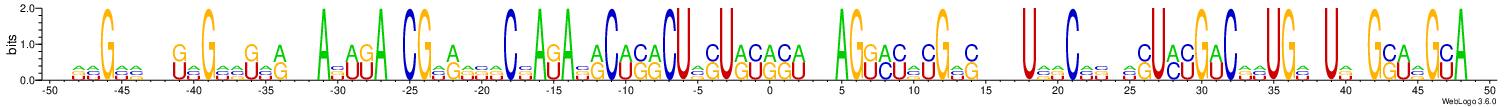

3_HITSCLIP_Ago2_binding_clusters


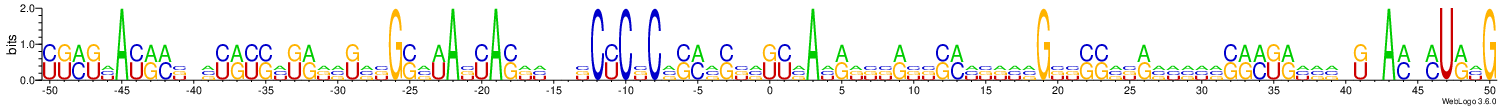

4_HITSCLIP_Ago2_binding_clusters_2


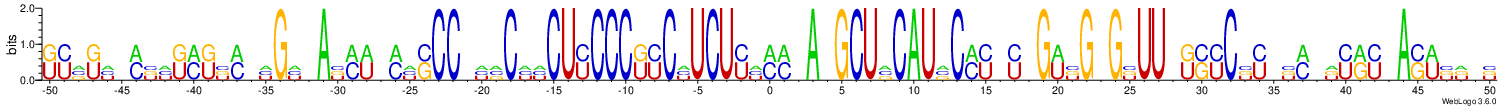

5_CLIPSEQ_AGO2_hg19


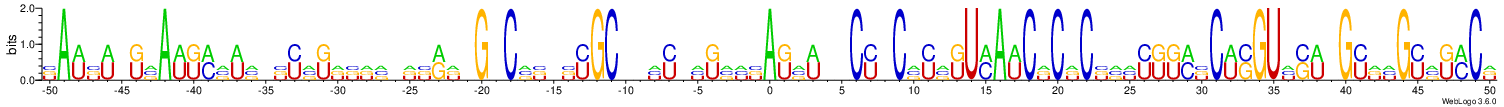

6_CLIP-seq-eIF4AIII_1


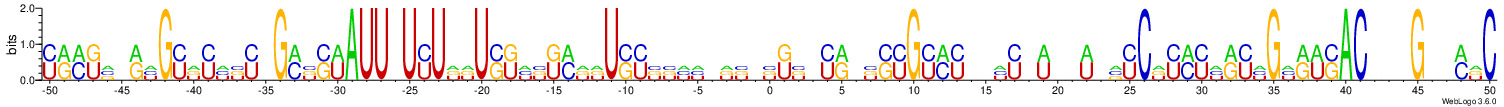

7_CLIP-seq-eIF4AIII_2


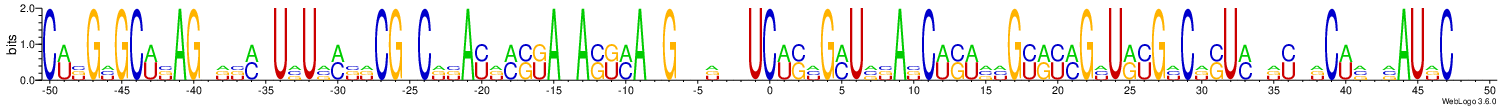

8_PARCLIP_ELAVL1_hg19


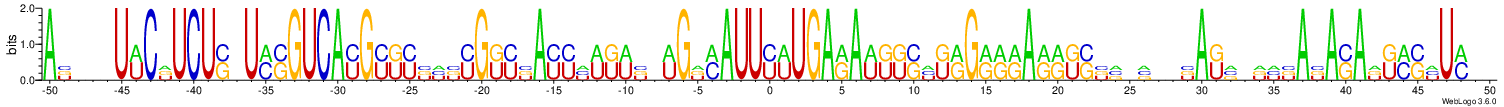

9_PARCLIP_ELAVL1MNASE_hg19


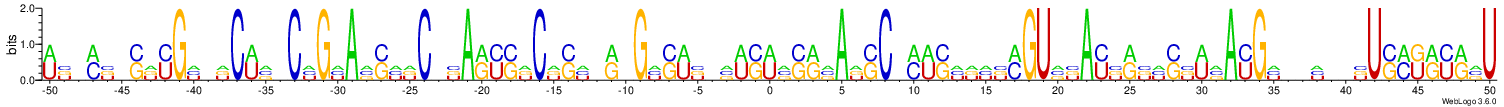

10_PARCLIP_ELAVL1A_hg19


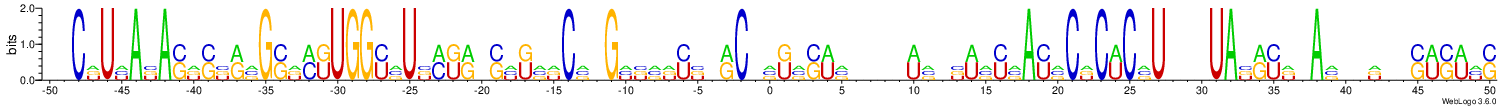

10_PARCLIP_ELAVL1A_hg19


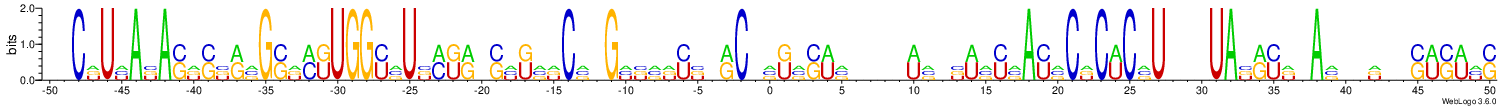

12_PARCLIP_EWSR1_hg19


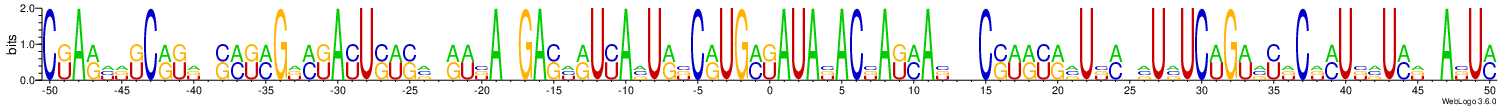

13_PARCLIP_FUS_hg19


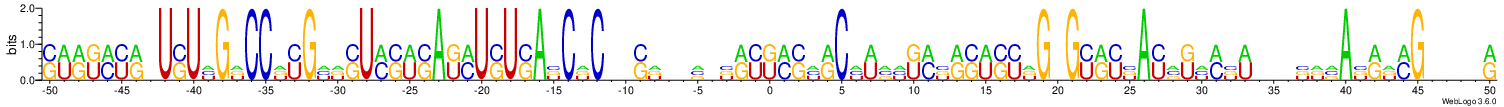

14_PARCLIP_FUS_mut_hg19


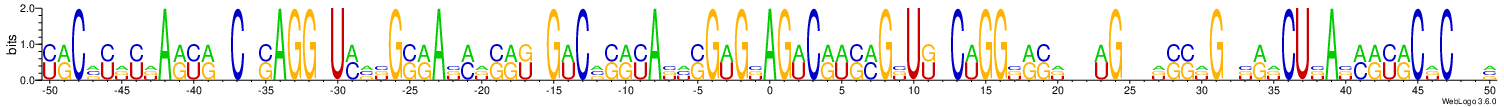

15_PARCLIP_IGF2BP123_hg19


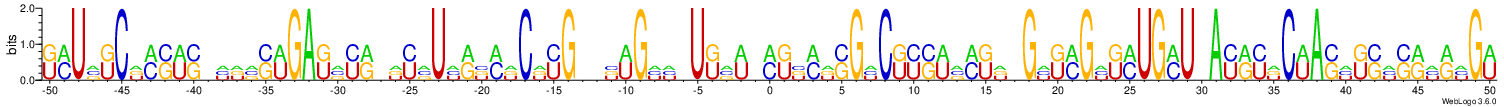

16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters


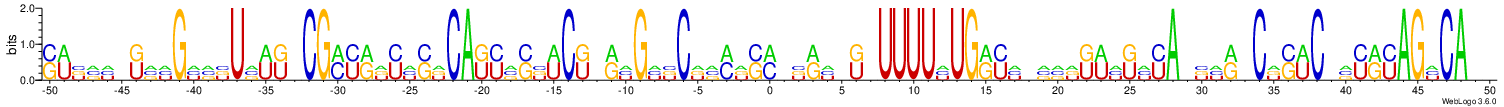

17_ICLIP_HNRNPC_hg19


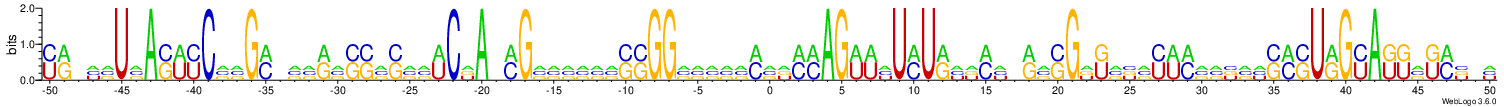

18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome


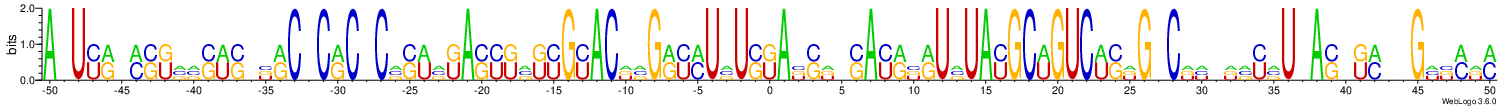

19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome


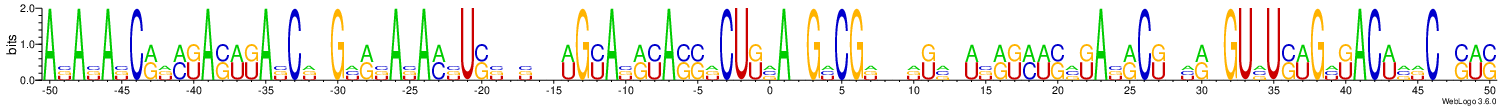

20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome


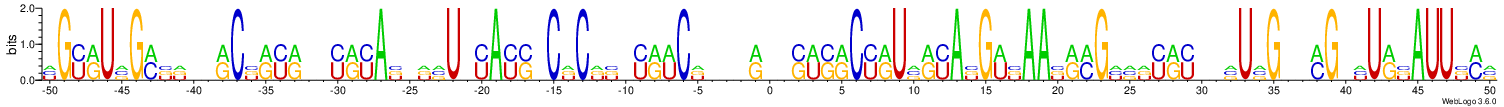

21_PARCLIP_MOV10_Sievers_hg19


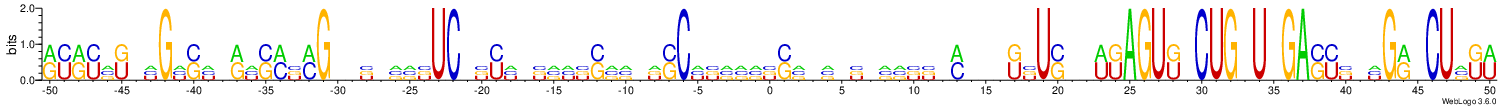

22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome


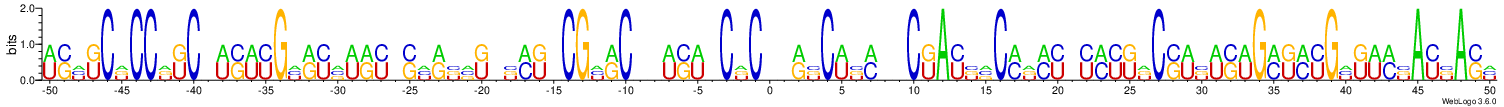

23_PARCLIP_PUM2_hg19


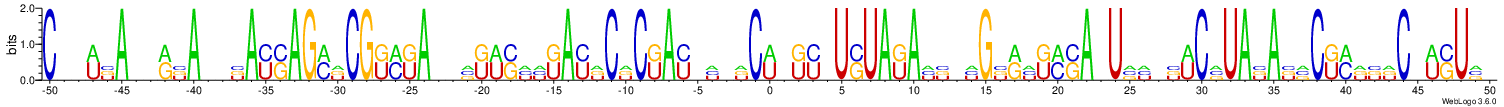

24_PARCLIP_QKI_hg19


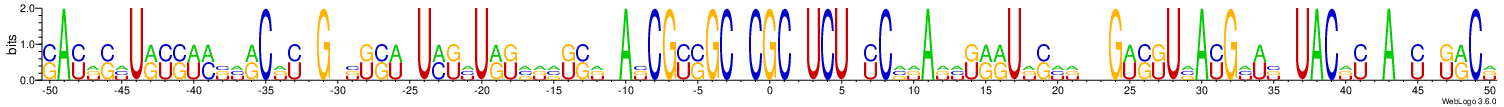

25_CLIPSEQ_SFRS1_hg19


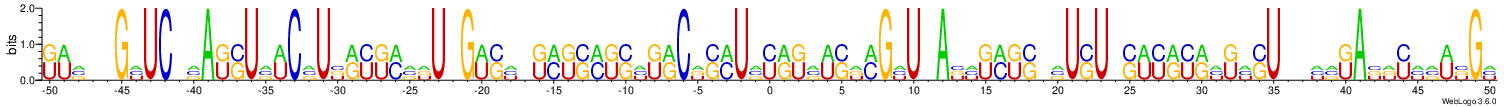

26_PARCLIP_TAF15_hg19


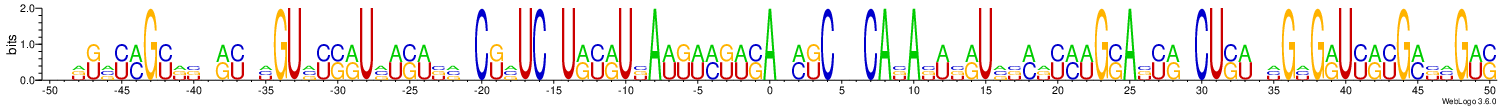

27_ICLIP_TDP43_hg19


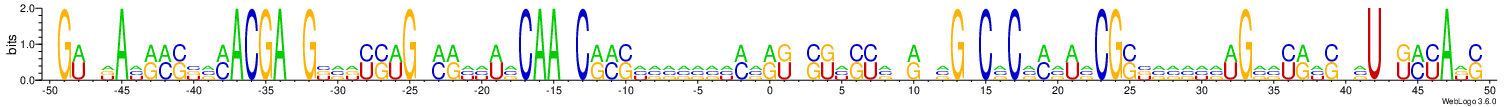

28_ICLIP_TIA1_hg19


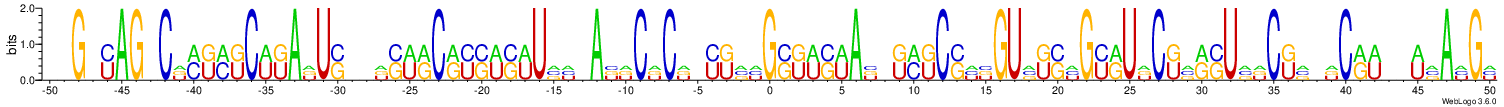

29_ICLIP_TIAL1_hg19


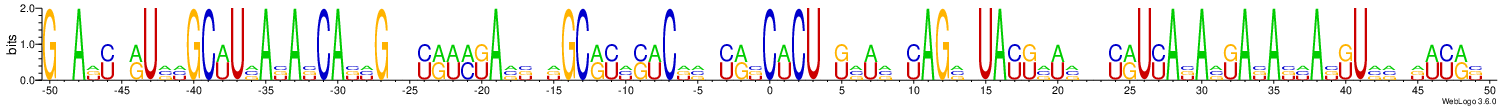

30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters


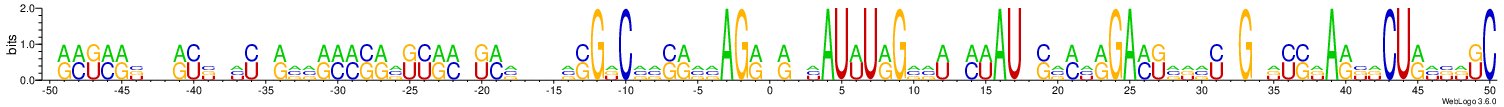

31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters


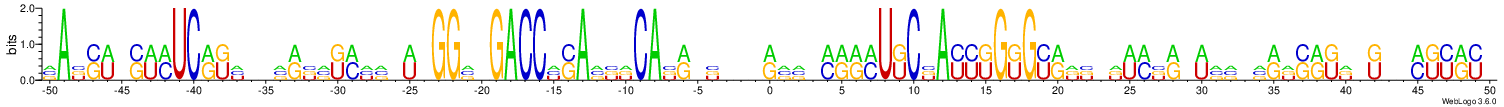

In [5]:
from IPython.display import display, Image
import os


protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)

        with open ("results/set_%s/%s/activation_maximization_2" % (training_set_number, protein), "r") as activation_maximization_f:
            activation = np.load(activation_maximization_f)
            
            nucleotides = {'A' : activation[:,0], 'T' : activation[:,1], 'G' : activation[:,2], 'C' : activation[:,3]} 
            position_count = np.sum(activation[:,0:4],1)

            for entry in nucleotides:
                nucleotides[entry] = np.nan_to_num(np.true_divide(nucleotides[entry],position_count))
                
            with open ("results/set_%s/%s/max_activation_sequences_2.txt" % (training_set_number, protein), "w") as sequences_f:
                 sequences_f.write('P0 A U G C\n')
                    
            for i in range (len(nucleotides['A'])):
                 with open ("results/set_%s/%s/max_activation_sequences_2.txt" % (training_set_number, protein), "a") as sequences_f:
                    sequences_f.write('P{} {} {} {} {}\n'.format(i+1, nucleotides['A'][i], nucleotides['T'][i], nucleotides['G'][i], nucleotides['C'][i]))
                    
                    
for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        cmd = ("weblogo -f results/set_%s/%s/max_activation_sequences_2.txt -D transfac -F png -o results/set_%s/%s/max_activation_2.png --errorbars NO --show-xaxis YES --show-yaxis YES --first-index '-50' -A rna --composition none -n 101 --color '#00CC00' 'A' 'A' --color '#0000CC' 'C' 'C' --color '#FFB300' 'G' 'G' --color '#CC0000' 'U' 'U' " % (training_set_number, protein, training_set_number, protein)) 
        os.system(cmd)
        display(Image('results/set_%s/%s/max_activation_2.png' % (training_set_number, protein)))
                